# Introduction to Business Analytics Project

In [1]:
import pandas as pd
import numpy as np
import math
#from tqdm import tqdm

import pickle

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import osmnx as ox
import holidays
from haversine import haversine, Unit
import shapely.geometry

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Dissable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting seeds
np.random.seed(42)

# 1 Introduction

# 2 Data analysis and visualization

In [5]:
# Loading the dataset 
data = pd.read_csv('Trips_2018.csv')

observations = data.shape[0]
attributes = data.shape[1]
print(f"Size of the dataset: {data.shape}")
print("Data snippet:")
data.head()

Size of the dataset: (17548339, 14)
Data snippet:


,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


As we can see, the dataset consists of 17,548,339 observations across 14 attributes. It includes key information about each bike trip, such as the start and end station IDs, trip duration, and the geographic coordinates (latitude and longitude) of the stations. Additionally, the dataset contains user-related information, including user type, birth year, and gender.

As part of the data preparation, all columns containing NaN values were removed from the dataset. Furthermore, both the start time and stop time variables were converted to datetime format. The “Unnamed” column, which served as an index column, was also removed.

In [ ]:
# Dropping unnamed column
data.drop(["Unnamed: 0"], axis=1, inplace=True)

# Removing NaN-values
data.dropna(inplace=True) 

# Converting times and dates to datetime format
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])
data['date'] = data['starttime'].dt.date


print(f"Size of the dataset: {data.shape}")
print(f"Removed {observations-data.shape[0]} NaN-values")
print("Data snippet:")
data.head()

Size of the dataset: (17545842, 13)
Removed 2497 NaN-values
Data snippet:


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


To bether understand the data - user analisys was apllied. looking into when the usage of the bikes was at it highest, as weel as how long the durations of the bikes usally where. 

The tripdurations where investigated for the data 

In [7]:
# Statistics of tripduration
print(f"""
Trip duration statistics (sec.):
Trip duration range (sec.): [{min(data['tripduration']):.2f}, {max(data['tripduration']):.2f}] 
Mean: {data['tripduration'].mean():.2f}
Median: {data['tripduration'].median():.2f}
STD:  {data['tripduration'].std():.2f}""")


Trip duration statistics (sec.):
Trip duration range (sec.): [61.00, 19510049.00] 
Mean: 988.47
Median: 605.00
STD:  18895.91


Based on this we can see that the maximum tripduration is much larger than both the mean and the median. This indicates that we have som kind of ourliers. 

To visualise the outliers, the histogram of the duration was plotted on poth linear and log axes

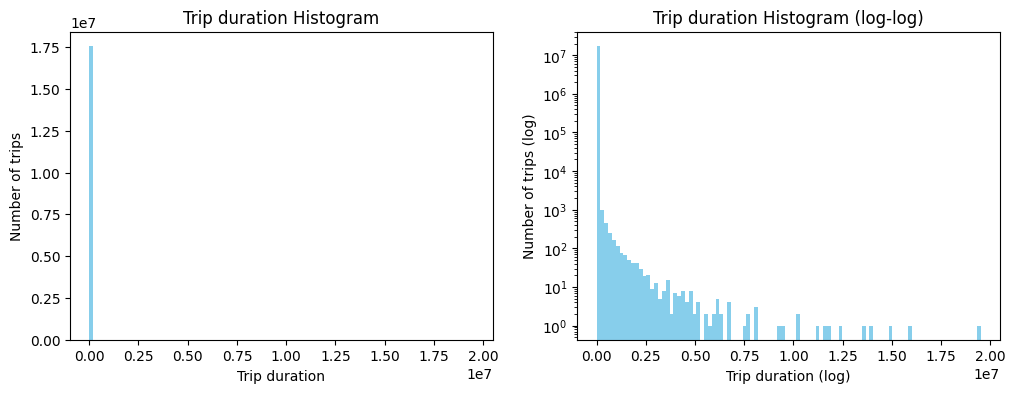

In [8]:
# Plotting the trip duration histogram on linear and log-log axes
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(data['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram')

plt.subplot(122)
plt.hist(data['tripduration'], bins=100, log=True, color='skyblue')
plt.xlabel('Trip duration (log)')
plt.ylabel('Number of trips (log)')
plt.title('Trip duration Histogram (log-log)')
plt.show()

To improve the quality of the data, outliers were removed. Outliers were defined as trips with a duration above the 99th percentile.

In [9]:
#Removing outliers
data_wo_outliers = data[data['tripduration'] <= data['tripduration'].quantile(0.99)]
print(f"""Number of observations removed as outliers:", {data.shape[0] - data_wo_outliers.shape[0]})
Size of the dataset after removing outliers: {data_wo_outliers.shape}
Trip duration range (sec.) after removing outliers: [{min(data_wo_outliers['tripduration']):.2f}, {max(data_wo_outliers['tripduration']):.2f}]
Mean after removing outliers: {data_wo_outliers['tripduration'].mean():.2f}
Median after removing outliers: {data_wo_outliers['tripduration'].median():.2f}
STD after removing outliers:  {data_wo_outliers['tripduration'].std():.2f}
""")
print()

Number of observations removed as outliers:", 175403)
Size of the dataset after removing outliers: (17370439, 13)
Trip duration range (sec.) after removing outliers: [61.00, 3505.00]
Mean after removing outliers: 776.67
Median after removing outliers: 599.00
STD after removing outliers:  576.04




Plotting the histogram of the data without outliers. 

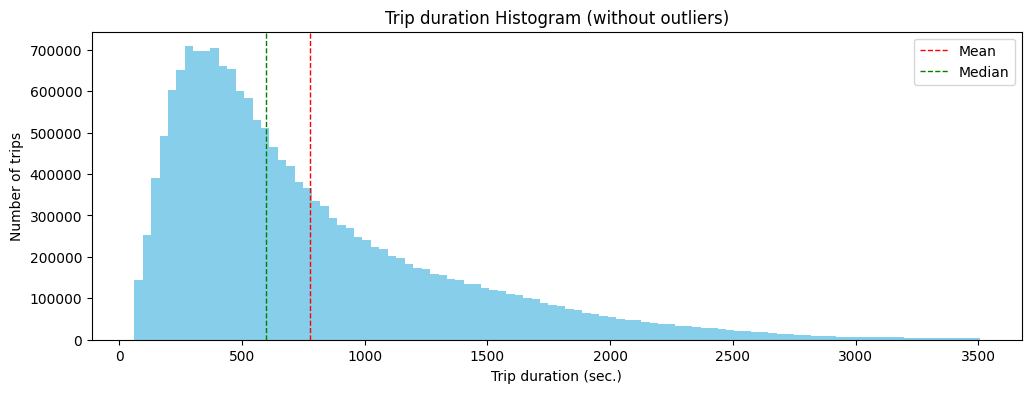

In [10]:
plt.figure(figsize=(12, 4))
plt.hist(data_wo_outliers['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration (sec.)')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram (without outliers)')
plt.axvline(data_wo_outliers['tripduration'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(data_wo_outliers['tripduration'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()    
plt.show()


### Usage patterns 
To understand usage patternes of the bikes, the usage is ninvistigated looking at usage yearly, weekly and daily. To se if it possible to see any tendensies in the data 

In [11]:


#Creating pickups dataframe
pickups = data_wo_outliers['starttime'].value_counts().reset_index()
pickups.columns = ['time', 'pickups']
pickups = pickups.set_index('time')
pickups.sort_index(inplace=True)

display(pickups.head()) 

# creating dropoff dataframe
dropoffs = data_wo_outliers['stoptime'].value_counts().reset_index()
dropoffs.columns = ['time', 'dropoffs']
dropoffs = dropoffs.set_index('time')
dropoffs.sort_index(inplace=True)
display(dropoffs.head()) 

# Merge dropoffs and pickups on index
pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

pickups_and_dropoffs.head()

# Adding weekdays and months to dataframe
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

print(f"""
Sanity check: 
Total amount of pickups = Total amount of dropoffs: {pickups['pickups'].sum()==dropoffs['dropoffs'].sum()}""")

,pickups
time,
2018-01-01 00:01:50.650,1
2018-01-01 00:02:43.918,1
2018-01-01 00:03:15.116,1
2018-01-01 00:06:43.709,1
2018-01-01 00:06:56.924,1


,dropoffs
time,
2018-01-01 00:05:07.438,1
2018-01-01 00:06:11.383,1
2018-01-01 00:12:59.450,1
2018-01-01 00:13:28.480,1
2018-01-01 00:13:39.792,1



Sanity check: 
Total amount of pickups = Total amount of dropoffs: True


Plotting the pickups and droppoff count for each month, to see if there are any months in the dataset where the bikes are used more frequently 

In [ ]:
# Plotting the pickups and dropoff counts for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December']
pick_drop = [pickups_and_dropoffs[pickups_and_dropoffs['month'] == i+1]['pickups'].sum() for i, month in enumerate(months)]

fig = go.Figure(data=[go.Bar(x=months, y=pick_drop, marker_color='skyblue')])
fig.update_layout(xaxis_title="Months", yaxis_title="Total Pickups", title="Monthly Pickups Summary", title_x=0.5, width=900,  height=400)
fig.show()

In [ ]:
# Plotting the pickups and dropoff counts for weekday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pick_drop = [pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]['pickups'].sum() for i, day in enumerate(days)]

fig = go.Figure(data=[go.Bar(x=days, y=pick_drop, marker_color='skyblue')])
fig.update_layout(xaxis_title="Weekdays", yaxis_title="Total Pickups", title="Weekly Pickups Summary", title_x=0.5, width=900,  height=400)
fig.show()

In [17]:
# Plotting the pickups in hourly intervals for every day of the week
fig = go.Figure()
for i, weekday in enumerate(days):
    weekdata = pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]
    grouped_data = weekdata.groupby(weekdata.index.hour).sum()[["pickups", "dropoffs"]]

    index = grouped_data.index
    pickups = grouped_data['pickups']
    fig.add_trace(go.Scatter(x=index, y=pickups, mode='lines', name=f'{weekday}'))

fig.update_layout(title='Pickups per weekday', xaxis_title='Hour of day', yaxis_title='Number of trips', title_x=0.5, width=900,  height=400)

for time in [7, 10, 16, 19]:
    fig.add_shape(type="line", x0=time, y0=0, x1=time, y1=300000, line=dict(color="RoyalBlue", width=1, dash="dot"))
fig.show()

# 3 Clustering 

# 4 Predictive Model

Mapping stations to cluster

In [ ]:
data = data.merge(station_to_cluster[['station_id','cluster_id']],
                  left_on='start_station_id',
                  right_on='station_id',
                  how='left')
data = data.rename(columns={'cluster_id':'cluster_departure'})

Departures per cluster per hour

In [ ]:
data['hour'] = data['starttime'].dt.floor('H')   # round down to hour

hourly_dep = (
    data.groupby(['cluster_departure', 'hour'])
        .size()
        .reset_index(name='pickups')
)
display(hourly_dep.head())

Arrivals per cluster per hour

In [ ]:
data['hour_arr'] = data['stoptime'].dt.floor('H')

hourly_arr = (
    data.groupby(['cluster_arrival', 'hour_arr'])
        .size()
        .reset_index(name='dropoffs')
)
display(hourly_arr.head())

Merging into one table per cluster and hour

In [ ]:
hourly = (
    hourly_dep
    .merge(hourly_arr, left_on=['cluster_departure','hour'],
                      right_on=['cluster_arrival','hour_arr'],
           how='outer')
)


# 5 Exploratory Component

# 6 Conclusion